# 0) Setup & Paths

In [1]:
import sys
from pathlib import Path

# 0.1) Make sure `src/` is on your PYTHONPATH
project_root = Path().cwd().parent
sys.path.insert(0, str(project_root / "src"))

# 0.2) Common imports
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio
import scipy.stats as stats

sns.set_context("notebook")
sns.set_style("whitegrid")
%matplotlib inline

# 0.3) Define where “raw” and “processed” live
RAW_ROOT  = project_root / "data" / "raw"
PROC_ROOT = project_root / "data" / "processed"

# sanity-check
print("RAW_ROOT:     ", RAW_ROOT)
print("PROC_ROOT:    ", PROC_ROOT)

RAW_ROOT:      c:\Users\mattt\Skripsie\Projects\DTW-project\data\raw
PROC_ROOT:     c:\Users\mattt\Skripsie\Projects\DTW-project\data\processed


# 1) Local Functions EDA

In [2]:
# 1.1) Point at the LocalFunctions folder
local_dir = RAW_ROOT / "LocalFunctions"
assert local_dir.exists(), f"{local_dir} not found"
files = sorted(local_dir.glob("*.mat"))
print(f"Found {len(files)} local-function files")

Found 11200 local-function files


In [3]:
# 1.2) Loader
def load_local(path: Path) -> np.ndarray:
    m = sio.loadmat(str(path), squeeze_me=True, struct_as_record=False)
    return m.get("localFunctions", np.empty((0,9)))

In [4]:
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor, as_completed

# 1.3) Collect lengths
# assume load_local is already imported from src.io.load_biosecurid
# and `files` is your list of Paths under LocalFunctions

pattern = re.compile(r"u(\d+)s(\d+)_sg(\d+)\.mat$")

def extract_length(path: Path) -> dict:
    arr = load_local(path)
    user, session, sample = pattern.match(path.name).groups()
    return {
        "user":    int(user),
        "session": int(session),
        "sample":  int(sample),
        "length":  arr.shape[0],
        "stem":    path.stem,
    }

rows = []
# spin up a thread for each core (or fewer if you like)
with ThreadPoolExecutor(max_workers=12) as exe:
    futures = {exe.submit(extract_length, p): p for p in files}
    for fut in as_completed(futures):
        try:
            rows.append(fut.result())
        except Exception as e:
            # if any file still errors, at least continue
            print(f"[ERROR] {futures[fut].name}: {e!r}")

length_df = pd.DataFrame(rows)
print(length_df.shape)
length_df.head()

(11200, 5)


,user,session,sample,length,stem
0,1001,1,7,195,u1001s0001_sg0007
1,1001,1,6,192,u1001s0001_sg0006
2,1001,2,2,199,u1001s0002_sg0002
3,1001,1,5,578,u1001s0001_sg0005
4,1001,2,1,199,u1001s0002_sg0001


In [5]:
# 1.4) Summary stats
print(f"Total signatures: {len(length_df)}")
print("Users:", length_df.user.nunique(), "Sessions:", length_df.session.nunique())
print(length_df.length.describe())

Total signatures: 11200
Users: 400 Sessions: 4
count    11200.000000
mean       724.455625
std        655.329478
min         45.000000
25%        325.000000
50%        522.000000
75%        904.250000
max      11819.000000
Name: length, dtype: float64


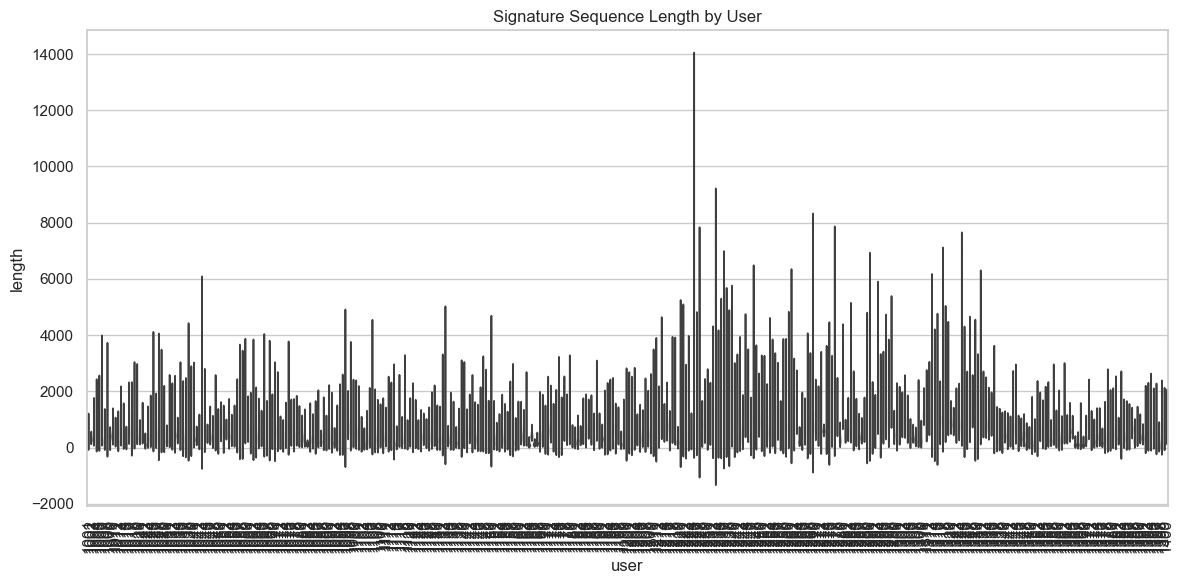

In [6]:
# 1.5) Violin plot of lengths
plt.figure(figsize=(12,6))
sns.violinplot(x="user", y="length", data=length_df, inner="quartile")
plt.xticks(rotation=90)
plt.title("Signature Sequence Length by User")
plt.tight_layout()

In [7]:
# 1.6) Link to “duration” global feature (f1)
global_dir = RAW_ROOT / "GlobalFeatures"
def get_duration(stem):
    f = global_dir / f"{stem}.mat"
    if not f.exists(): 
        return np.nan
    vf = sio.loadmat(str(f), squeeze_me=True)["globalFeatures"]
    return float(vf[0])  # f1

length_df["duration"] = length_df.stem.map(get_duration)

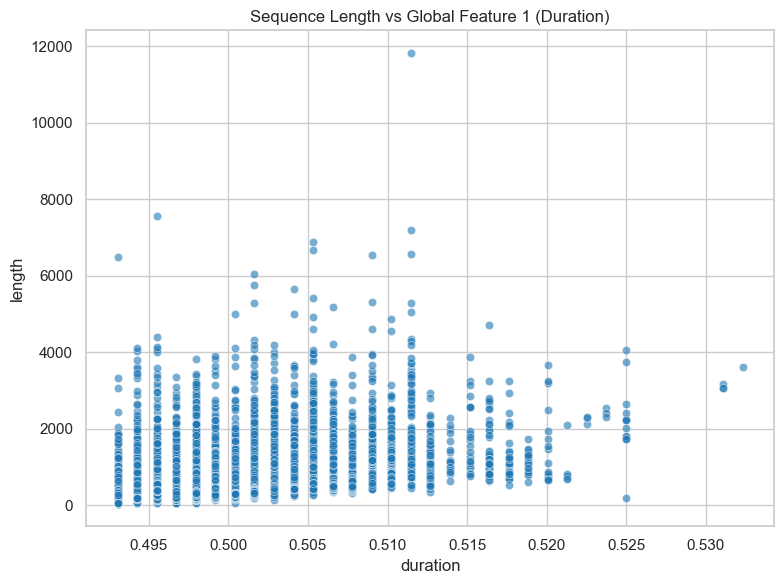

In [8]:
# 1.7) Scatter length vs duration
plt.figure(figsize=(8,6))
sns.scatterplot(x="duration", y="length", data=length_df, alpha=0.6)
plt.title("Sequence Length vs Global Feature 1 (Duration)")
plt.tight_layout()

# Global Features EDA

In [9]:
# 2.1) Point at the GlobalFeatures folder
global_dir = RAW_ROOT / "GlobalFeatures"
assert global_dir.exists(), f"{global_dir} not found"
files = sorted(global_dir.glob("*.mat"))
print(f"Found {len(files)} global-feature files")

Found 11200 global-feature files


In [10]:
# 2.2) Loader & collect
def load_global(path: Path) -> np.ndarray:
    m = sio.loadmat(str(path), squeeze_me=True, struct_as_record=False)
    if "globalFeatures" not in m:
        raise KeyError(f"{path.name} missing globalFeatures")
    arr = np.asarray(m["globalFeatures"]).squeeze()
    if arr.size != 40:
        raise ValueError(f"{path.name}: expected 40, got {arr.shape}")
    return arr.astype(float)

records = []
for p in files:
    uid, sess, samp = map(int, pattern.match(p.name).groups())
    gf = load_global(p)
    records.append((uid, sess, samp, *gf))
cols = ["user","session","sample"] + [f"f{i+1}" for i in range(40)]
df = pd.DataFrame.from_records(records, columns=cols)
print(f"Loaded {len(df)} records.")

Loaded 11200 records.


In [11]:
# 2.3) Basic counts
summary_df = pd.DataFrame([{
    "n_signatures": len(df),
    "n_users":      df.user.nunique(),
    "n_sessions":   df.session.nunique(),
    "features_per_signature": 40
}])
print(summary_df.to_string(index=False))

 n_signatures  n_users  n_sessions  features_per_signature
        11200      400           4                      40


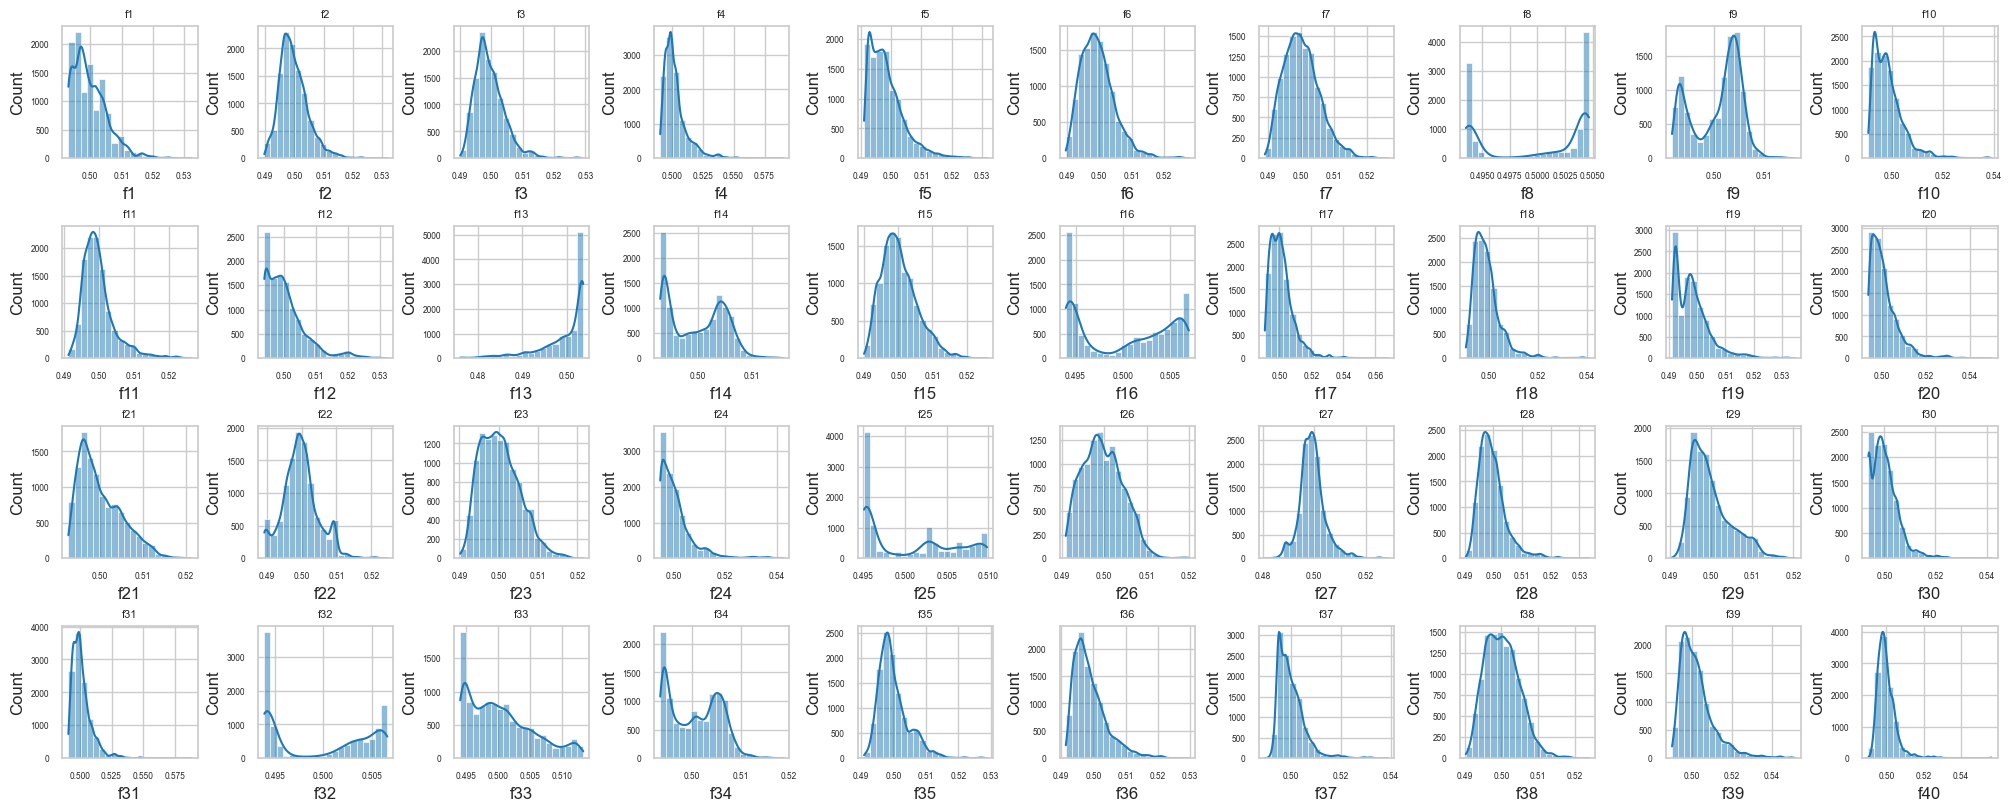

In [12]:
# 2.4) Histograms of each feature
fig, axes = plt.subplots(4,10, figsize=(20,8), constrained_layout=True)
axes = axes.ravel()
for i in range(40):
    sns.histplot(df[f"f{i+1}"], ax=axes[i], kde=True, bins=20, edgecolor=None)
    axes[i].set_title(f"f{i+1}", fontsize=8)
    axes[i].tick_params(labelsize=6)
for ax in axes[40:]:
    ax.axis("off")

In [13]:
# 2.5) Outlier detection (>3σ)
X = df[[f"f{i+1}" for i in range(40)]].values
z = stats.zscore(X, nan_policy="omit", axis=0)
out_counts = (np.abs(z) > 3).sum(axis=0)
out_df = pd.DataFrame({
    "feature": [f"f{i+1}" for i in range(40)],
    "outliers": out_counts,
    "prop": out_counts / len(df)
})
print(out_df)

   feature  outliers      prop
0       f1       176  0.015714
1       f2       126  0.011250
2       f3       111  0.009911
3       f4       232  0.020714
4       f5       185  0.016518
5       f6       114  0.010179
6       f7        51  0.004554
7       f8         0  0.000000
8       f9         2  0.000179
9      f10       154  0.013750
10     f11       209  0.018661
11     f12       274  0.024464
12     f13       220  0.019643
13     f14         6  0.000536
14     f15        98  0.008750
15     f16         0  0.000000
16     f17       171  0.015268
17     f18       186  0.016607
18     f19       219  0.019554
19     f20       209  0.018661
20     f21        53  0.004732
21     f22        48  0.004286
22     f23        68  0.006071
23     f24       204  0.018214
24     f25         0  0.000000
25     f26        23  0.002054
26     f27       156  0.013929
27     f28       198  0.017679
28     f29        89  0.007946
29     f30       148  0.013214
30     f31       228  0.020357
31     f

Text(0.5, 1.0, 'Missing / Non-finite Values')

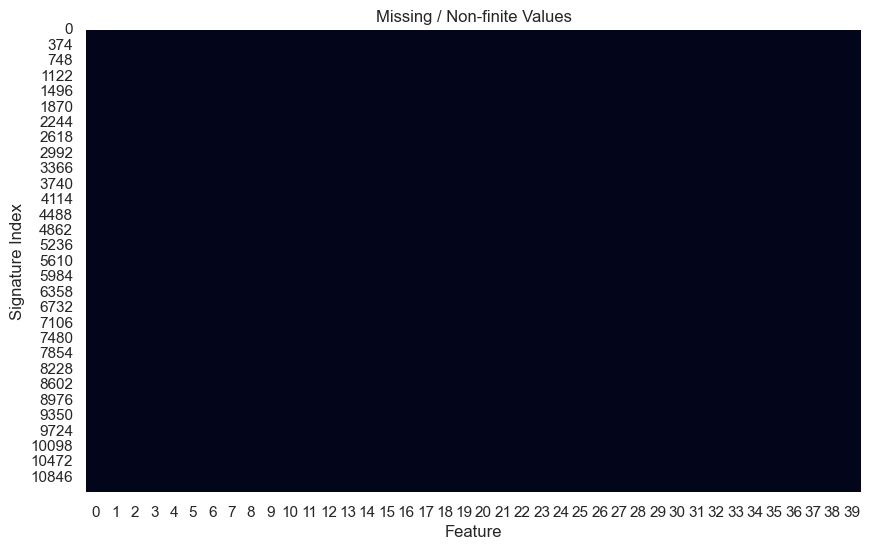

In [14]:
# 2.6) Missing / non-finite heatmap
mask = ~np.isfinite(X)
plt.figure(figsize=(10,6))
sns.heatmap(mask, cbar=False)
plt.xlabel("Feature")
plt.ylabel("Signature Index")
plt.title("Missing / Non-finite Values")

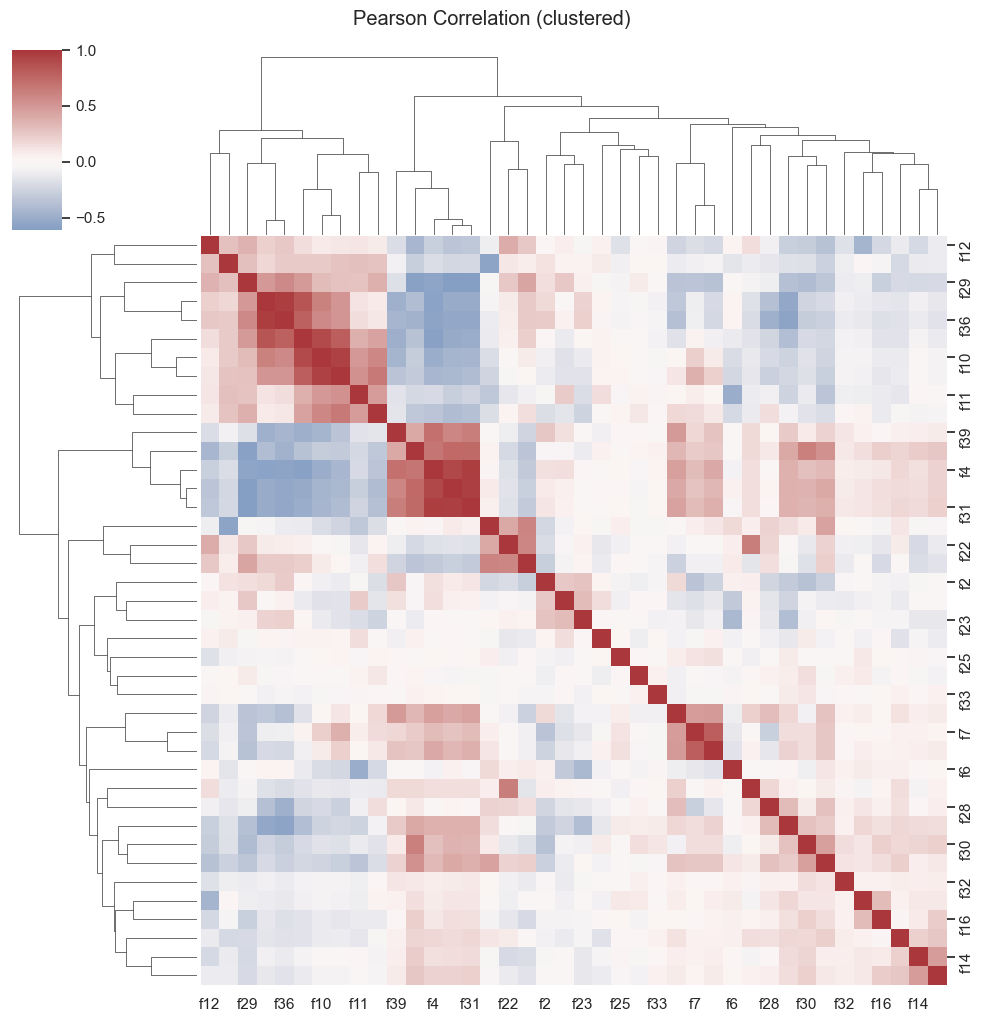

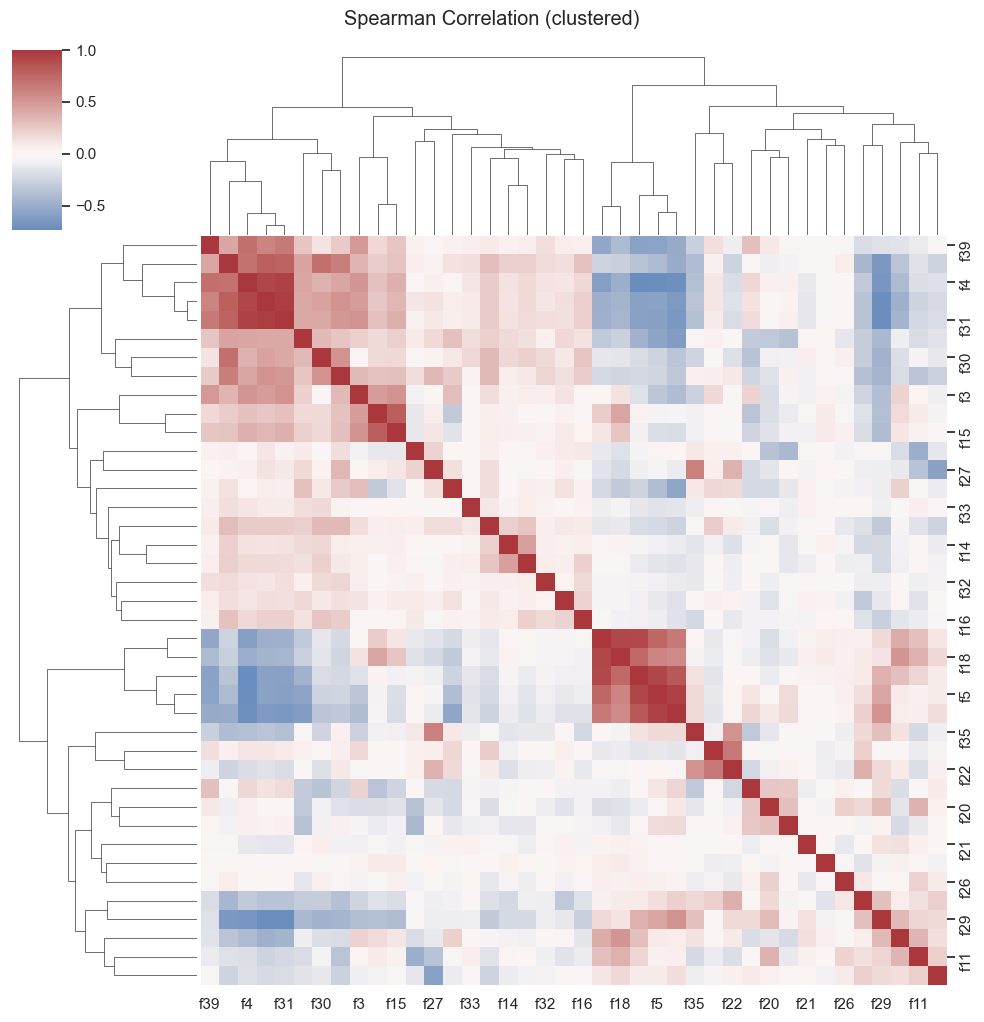

In [15]:
# 2.7) Correlation matrices
feat_cols = [f"f{i+1}" for i in range(40)]
pear = df[feat_cols].corr(method="pearson")
spear = df[feat_cols].corr(method="spearman")

# clustered heatmap
cg = sns.clustermap(pear, cmap="vlag", center=0, figsize=(10,10))
cg.fig.suptitle("Pearson Correlation (clustered)", y=1.02)
plt.show()

cg = sns.clustermap(spear, cmap="vlag", center=0, figsize=(10,10))
cg.fig.suptitle("Spearman Correlation (clustered)", y=1.02)
plt.show()